In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
from scipy.optimize import minimize
from itertools import combinations
from math import sqrt
from scipy.stats import norm

In [2]:
#Importamos el market data del portafolio

data = pd.read_excel("PreciosPortf.xlsx", index_col=0)
data.head()

,ASURB MF Equity,GFNORTEO MF Equity,PE&OLES* MF Equity,WALMEX* MF Equity,IENOVA* MF Equity
DATE,,,,,
2016-01-01,243.89,94.99,177.22,43.49,72.34
2016-01-04,238.29,91.79,175.90,42.84,72.98
2016-01-05,233.03,91.72,176.45,42.66,71.48
2016-01-06,231.97,91.63,172.68,42.38,70.94
2016-01-07,230.71,89.54,172.94,39.99,72.31


In [3]:
#Generamos la matriz de rendimeinto y limpiamos los registros en donde exista un NA

rend = data.pct_change().dropna()
rend.head()

,ASURB MF Equity,GFNORTEO MF Equity,PE&OLES* MF Equity,WALMEX* MF Equity,IENOVA* MF Equity
DATE,,,,,
2016-01-04,-0.022961,-0.033688,-0.007448,-0.014946,0.008847
2016-01-05,-0.022074,-0.000763,0.003127,-0.004202,-0.020554
2016-01-06,-0.004549,-0.000981,-0.021366,-0.006564,-0.007555
2016-01-07,-0.005432,-0.022809,0.001506,-0.056395,0.019312
2016-01-08,-0.004118,-0.007706,-0.003180,0.026007,-0.017148


In [4]:
#Generamos un base en donde solo conservemos el ticker del instrumento y generamos la matriz de rendimientos

columnas2 = []
for c in data.columns:
    columnas2.append(c.replace(" MF Equity",""))

data.columns = columnas2
rend.columns = columnas2

In [5]:
rend.head()

,ASURB,GFNORTEO,PE&OLES*,WALMEX*,IENOVA*
DATE,,,,,
2016-01-04,-0.022961,-0.033688,-0.007448,-0.014946,0.008847
2016-01-05,-0.022074,-0.000763,0.003127,-0.004202,-0.020554
2016-01-06,-0.004549,-0.000981,-0.021366,-0.006564,-0.007555
2016-01-07,-0.005432,-0.022809,0.001506,-0.056395,0.019312
2016-01-08,-0.004118,-0.007706,-0.003180,0.026007,-0.017148


In [6]:
#Generamos el vector de rendimiento promedio anualizado del portafolio por emisora
rend_ports = rend.mean()*252
rend_ports

ASURB       0.123539
GFNORTEO    0.078811
PE&OLES*    0.111053
WALMEX*     0.082426
IENOVA*     0.078997
dtype: float64

In [7]:
#Ahora se definen 2 funciones que servirán para el calculo del rendimiento (port_rend) y volatilidad (port_vol)

def port_rend(weights,r):
    E_p = (rend.mean() * weights).sum()*252
    return E_p

def port_vol(weights,r):
    S_p = np.sqrt(weights.T @ (r.cov()*252)@weights)
    return S_p

In [8]:
#Ahora vamos a generar portafolios simulados, para lo cual debemos generar una matriz de "Nùmero de portafolios a simular"x"Nùmero de acciones en el portafiolio"

weights_sim = np.random.random((5000,5))
weights_sim = weights_sim / weights_sim.sum(axis=1,keepdims=True)
weights_sim

array([[0.18337064, 0.28241317, 0.19756518, 0.18656875, 0.15008225],
       [0.05188167, 0.27735941, 0.09916146, 0.25052235, 0.32107511],
       [0.04197284, 0.10026287, 0.03431153, 0.44541995, 0.37803281],
       ...,
       [0.26294848, 0.27960179, 0.18238984, 0.03096832, 0.24409159],
       [0.31104678, 0.14447869, 0.05226009, 0.39189024, 0.1003242 ],
       [0.163054  , 0.01055784, 0.33638745, 0.45319235, 0.03680837]])

In [9]:
#Solo como validación, se demuestra que todos los pesos suman 1.

sum(weights_sim.sum(axis=1))

5000.0

In [10]:
rend_sim = np.apply_along_axis(port_rend,1,weights_sim,r=rend)
vol_sim = np.apply_along_axis(port_vol,1,weights_sim,r=rend)

In [11]:
#Generamos un vector que contenga el sharpe ratio para cada escenario simulado

sharpe_ratio = rend_sim / vol_sim

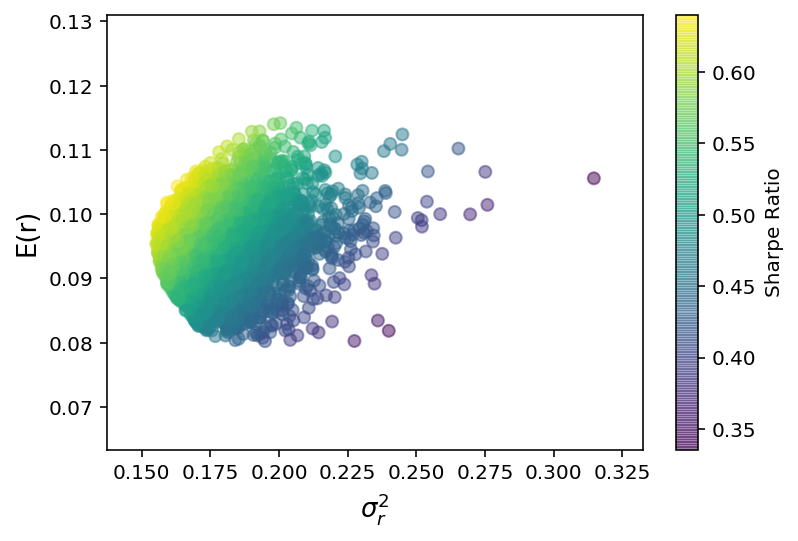

In [12]:
#Graficamos el conjunto de portafolio simulados, relacionados con su rendimiento y volatilidad
%config InlineBackend.figure_format='retina'
plt.scatter(vol_sim,rend_sim, c=sharpe_ratio,alpha=.5)
plt.colorbar(label="Sharpe Ratio",)
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)",fontsize=13);

In [13]:
#Ahora definimos las funciones que utilizaremos para los contraints de la optimizaciòn

def sum_weights(weights):
    return weights.sum()-1

def rend_esperado(weights, E):
    return port_rend(weights, rend) - E

def allocation(weights,i,j):
    w1 = weights[i]
    w2 = weights[j]
    return -(w1+w2) + .80

def neg_weigts(weights):
    return min(weights) + .05

In [14]:
#Ahora vamos a definir un rango sobre el cual podamos genrar la frontera, tomando como lìmites los rendimeintos mínimos y máximos del portafolio inicial

rmin = rend_ports.min()
rmax = rend_ports.max()
rend_maxs = np.linspace(rmin,rmax)
rend_maxs

array([0.07881127, 0.07972409, 0.08063691, 0.08154972, 0.08246254,
       0.08337536, 0.08428817, 0.08520099, 0.0861138 , 0.08702662,
       0.08793944, 0.08885225, 0.08976507, 0.09067789, 0.0915907 ,
       0.09250352, 0.09341633, 0.09432915, 0.09524197, 0.09615478,
       0.0970676 , 0.09798041, 0.09889323, 0.09980605, 0.10071886,
       0.10163168, 0.1025445 , 0.10345731, 0.10437013, 0.10528294,
       0.10619576, 0.10710858, 0.10802139, 0.10893421, 0.10984702,
       0.11075984, 0.11167266, 0.11258547, 0.11349829, 0.11441111,
       0.11532392, 0.11623674, 0.11714955, 0.11806237, 0.11897519,
       0.119888  , 0.12080082, 0.12171364, 0.12262645, 0.12353927])

In [15]:
#Vamos a generar la frontera eficiente para un portafolio de mìnima volatilidad,obteniendo los pesos óptimos sobre todo el intervalo de rend_maxs

pesos_optimos = []
N, M = rend.shape
w_opt = np.random.randn(M)

for e in rend_maxs:
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w_opt: rend_esperado(w_opt,e)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,0,1)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,0,2)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,0,3)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,0,4)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,1,2)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,1,3)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,1,4)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,2,3)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,2,4)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,3,4)}

    ]

    
    port_opt = minimize(port_vol, w_opt,  constraints = constraints, args=rend)
    w_opt = port_opt.x
    pesos_optimos.append(w_opt)
    
pesos_optimos

[array([-0.05437076,  0.22470955,  0.02966121,  0.38700559,  0.41299441]),
 array([-0.03613329,  0.20382082,  0.03231248,  0.39039121,  0.40960879]),
 array([-0.01814677,  0.18270208,  0.0354447 ,  0.3925278 ,  0.4074722 ]),
 array([0.00202294, 0.16248706, 0.03549   , 0.39521234, 0.40478766]),
 array([0.0199707 , 0.15233514, 0.03941303, 0.39105314, 0.397228  ]),
 array([0.0382691 , 0.1442994 , 0.04300448, 0.38555346, 0.38887356]),
 array([0.05663403, 0.13665374, 0.04653546, 0.37977604, 0.38040074]),
 array([0.07500282, 0.12908069, 0.05006823, 0.37393557, 0.37191269]),
 array([0.09337227, 0.12152104, 0.05360169, 0.36808098, 0.36342403]),
 array([0.11174189, 0.11396379, 0.05713525, 0.36222317, 0.3549359 ]),
 array([0.13011157, 0.10640689, 0.06066883, 0.35636461, 0.3464481 ]),
 array([0.14848127, 0.09884998, 0.06420239, 0.35050585, 0.33796051]),
 array([0.16685098, 0.09129296, 0.06773595, 0.34464703, 0.32947309]),
 array([0.18522069, 0.08373582, 0.07126949, 0.33878817, 0.32098582]),
 arra

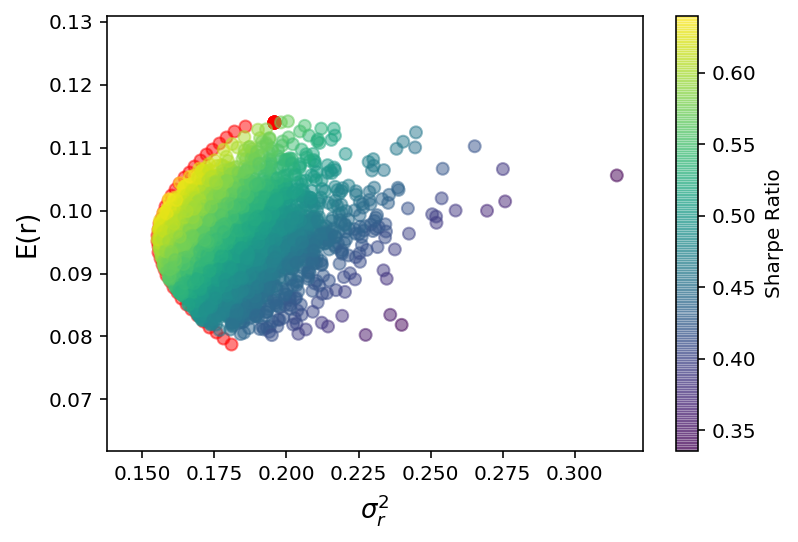

In [16]:
r_opt = []
v_opt = []

for w in pesos_optimos:
    r_opt.append(port_rend(w,rend))
    v_opt.append(port_vol(w,rend))

r_opt = np.array(r_opt)
v_opt = np.array(v_opt)

plt.scatter(v_opt,r_opt, c= "red",alpha=.5)
plt.scatter(vol_sim, rend_sim, c=sharpe_ratio, alpha = 0.5)
plt.colorbar(label="Sharpe Ratio",)
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)",fontsize=13);

In [17]:
#Seleccionamos los pesos del portafolio que genere el mayor rendimiento
pesos = pesos_optimos[r_opt.argmax()]

In [18]:
#Ahora generamos la matriz de covarianzas

covarianzas = rend.cov()
covarianzas

,ASURB,GFNORTEO,PE&OLES*,WALMEX*,IENOVA*
ASURB,0.000224,0.000086,0.000061,0.000036,0.000044
GFNORTEO,0.000086,0.000341,0.000094,0.000082,0.000082
PE&OLES*,0.000061,0.000094,0.000548,0.000041,0.000045
WALMEX*,0.000036,0.000082,0.000041,0.000215,0.000043
IENOVA*,0.000044,0.000082,0.000045,0.000043,0.000226


In [19]:
#Definimos una función que nos permita calcular la volatilidad del portafolio

def desvest_portafolio(weights,r):
    diaria = np.sqrt(weights.T @ r.cov()@weights)
    anual = diaria*sqrt(252)
    return diaria, anual

In [21]:
#Definimos el vector de posiciones
S = 10000000
posiciones = S*pesos

### VaR bajo un nivel de confianza de 95%

In [22]:
N1 = norm.ppf(0.95)
VaR_diario_95 = S * N1 * desvest_portafolio(pesos,rend)[0]
VaR_anual_95 = S * N1 * desvest_portafolio(pesos,rend)[1]
print(f"Var Diario = {VaR_diario_95:,.2f}")
print(f"Var Anual = {VaR_anual_95:,.2f}")

Var Diario = 202,699.19
Var Anual = 3,217,749.82


In [23]:

volatilidad_diaria_95 = np.sqrt(np.diag(covarianzas.to_numpy()))
volatilidad_anual_95 = volatilidad_diaria_95 * np.sqrt(252)
VAR_individual_diario_95 = posiciones * volatilidad_diaria_95 * N1
VAR_individual_anual_95= posiciones * volatilidad_anual_95 * N1


In [24]:
pd.options.display.float_format = '{:,.2f}'.format
resumen_95 = pd.DataFrame(list(zip(columnas2,pesos, posiciones,volatilidad_diaria_95,volatilidad_anual_95,VAR_individual_diario_95,VAR_individual_anual_95)), 
               columns =['Emisora','% Participación', 'Valuación','Volatilidad diaria','Volatilidad anual','VaR Diario (Individual)','VaR Anual (Individual)'])

In [25]:
resumen_95

,Emisora,% Participación,Valuación,Volatilidad diaria,Volatilidad anual,VaR Diario (Individual),VaR Anual (Individual)
0,ASURB,0.73,"7,333,333.33",0.01,0.24,"180,447.00","2,864,507.27"
1,GFNORTEO,0.07,"666,666.67",0.02,0.29,"20,260.17","321,620.29"
2,PE&OLES*,0.07,"666,666.67",0.02,0.37,"25,665.85","407,432.72"
3,WALMEX*,0.07,"666,666.67",0.01,0.23,"16,085.12","255,343.30"
4,IENOVA*,0.07,"666,666.67",0.02,0.24,"16,469.73","261,448.87"


### VaR bajo un nivel de confianza de 99%

In [26]:
N2 = norm.ppf(0.99)
VaR_diario_99 = S * N2 * desvest_portafolio(pesos,rend)[0]
VaR_anual_99 = S * N2 * desvest_portafolio(pesos,rend)[1]
print(f"Var Diario = {VaR_diario_99:,.2f}")
print(f"Var Anual = {VaR_anual_99:,.2f}")

Var Diario = 286,681.33
Var Anual = 4,550,924.97


In [27]:
volatilidad_diaria_99 = np.sqrt(np.diag(covarianzas.to_numpy()))
volatilidad_anual_99 = volatilidad_diaria_99 * np.sqrt(252)
VAR_individual_diario_99 = posiciones * volatilidad_diaria_99 * N2
VAR_individual_anual_99= posiciones * volatilidad_anual_99 * N2

In [28]:
pd.options.display.float_format = '{:,.2f}'.format
resumen_99 = pd.DataFrame(list(zip(columnas2,pesos, posiciones,volatilidad_diaria_99,volatilidad_anual_99,VAR_individual_diario_99,VAR_individual_anual_99)), 
               columns =['Emisora','% Participación', 'Valuación','Volatilidad diaria','Volatilidad anual','VaR Diario (Individual)','VaR Anual (Individual)'])

In [29]:
resumen_99

,Emisora,% Participación,Valuación,Volatilidad diaria,Volatilidad anual,VaR Diario (Individual),VaR Anual (Individual)
0,ASURB,0.73,"7,333,333.33",0.01,0.24,"255,209.63","4,051,327.29"
1,GFNORTEO,0.07,"666,666.67",0.02,0.29,"28,654.35","454,873.72"
2,PE&OLES*,0.07,"666,666.67",0.02,0.37,"36,299.70","576,239.88"
3,WALMEX*,0.07,"666,666.67",0.01,0.23,"22,749.49","361,136.90"
4,IENOVA*,0.07,"666,666.67",0.02,0.24,"23,293.45","369,772.13"


## Efecto de diversificación anual y diario para niveles de 95% y 99%
### (VaR individual - VaR Portafolio)

In [30]:
diver_d_95 = resumen_95["VaR Diario (Individual)"].sum() - VaR_diario_95
diver_a_95 = resumen_95["VaR Anual (Individual)"].sum() - VaR_anual_95
diver_d_99 = resumen_99["VaR Diario (Individual)"].sum() - VaR_diario_99
diver_a_99 = resumen_99["VaR Anual (Individual)"].sum() - VaR_anual_99

In [31]:
print(f"Efecto diversificación diario considerando un nivel de confianza del 95% = {diver_d_95:,.2f}")
print(f"Efecto diversificación diario considerando un nivel de confianza del 99% = {diver_d_99:,.2f}")
print(f"Efecto diversificación daual considerando un nivel de confianza del 95% = {diver_a_95:,.2f}")
print(f"Efecto diversificación daual considerando un nivel de confianza del 99% = {diver_a_99:,.2f}")

Efecto diversificación diario considerando un nivel de confianza del 95% = 56,228.68
Efecto diversificación diario considerando un nivel de confianza del 99% = 79,525.30
Efecto diversificación daual considerando un nivel de confianza del 95% = 892,602.64
Efecto diversificación daual considerando un nivel de confianza del 99% = 1,262,424.94
